The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed.

<b>The classification goal</b> - to predict if the client will subscribe a term deposit (variable y).

Number of Instances: 45211 for bank-full.csv (4521 for bank.csv)
Number of Attributes: 16 + output attribute.

<b>Input variables</b>

<b>bank client data</b>
1 - age (numeric) 2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed) 4 - education (categorical: "unknown","secondary","primary","tertiary") 5 - default: has credit in default? (binary: "yes","no") 6 - balance: average yearly balance, in euros (numeric) 7 - housing: has housing loan? (binary: "yes","no") 8 - loan: has personal loan? (binary: "yes","no")

<b>related with the last contact of the current campaign</b>
9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 10 - day: last contact day of the month (numeric) 11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec") 12 - duration: last contact duration, in seconds (numeric)

<b>other attributes</b>
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted) 15 - previous: number of contacts performed before this campaign and for this client (numeric) 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

<b>Output variable</b>
17 - y - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: None

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import learning_curve


import warnings
warnings.filterwarnings('ignore')

Data preprocessing

In [3]:
bank = pd.read_csv('bank-full.csv')
bank = pd.DataFrame(bank)
bank.isnull().sum()
bank.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

In [4]:
def prepareData(bank):
  #  print("****************************** General info ******************************")
    #print(bank.shape)
    #print(bank.head())
   # print("\n>>> value counts of target variable:\n")
    #print(bank['y'].value_counts())

    le = LabelEncoder()
    bank['y'] = le.fit_transform(bank['y'])

    #print("\n>>> Data related to client\n")
    client = bank.iloc[:,0:8]
    labelencoder_X = LabelEncoder()
    client['default']  = labelencoder_X.fit_transform(client['default']) 
    client['housing']  = labelencoder_X.fit_transform(client['housing']) 
    client['loan']     = labelencoder_X.fit_transform(client['loan']) 
    client = pd.get_dummies(client, drop_first=True)


    #print("\n>>> Data related to last contact\n")
    last_cont = bank.iloc[:,8:12]
    labelencoder_X = LabelEncoder()
    last_cont['month']       = labelencoder_X.fit_transform(last_cont['month']) 
    #last_cont['day'] = labelencoder_X.fit_transform(last_cont['day']) 
    last_cont = pd.get_dummies(last_cont, drop_first=True)


    #print("\n>>> others features\n")
    others = bank.iloc[:,12:16]
    #others['poutcome'].replace(['unknown', 'failure', 'success','other'], [1,2,3,4], inplace  = True)
    others = pd.get_dummies(others, drop_first=True)
    #print("\n>>> final form of data\n")
    final= pd.concat([client, last_cont,others], axis = 1)
    final.shape
    final = pd.concat([final,bank['y']],axis = 1)
    #print(final.head())

    #split data
    X=final.drop("y",axis=1)
    y = final['y']
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)

    #standarization
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    return X_train, y_train, X_valid, y_valid, X_test, y_test, final

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test, final = prepareData(bank)
final.head()

,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,duration,contact_telephone,contact_unknown,campaign,pdays,previous,poutcome_other,poutcome_success,poutcome_unknown,y
0,58,0,2143,1,0,0,0,0,1,0,...,261,0,1,1,-1,0,0,0,1,0
1,44,0,29,1,0,0,0,0,0,0,...,151,0,1,1,-1,0,0,0,1,0
2,33,0,2,1,1,0,1,0,0,0,...,76,0,1,1,-1,0,0,0,1,0
3,47,0,1506,1,0,1,0,0,0,0,...,92,0,1,1,-1,0,0,0,1,0
4,33,0,1,0,0,0,0,0,0,0,...,198,0,1,1,-1,0,0,0,1,0


In [5]:
for i in range(1,7):
    pca = PCA(n_components=i*5)
    pca.fit(X_train)
    print(i*5, pca.explained_variance_ratio_.sum())

5 0.3322783549363608
10 0.5118244164630351
15 0.6746462288836544
20 0.820215585695255
25 0.934320116301499
30 0.9929835288564259


In [6]:
def find_thresh_and_f1(clf, X_valid, y_valid):
    best_f1=0
    best_thresh=0
    thresh = 0.05
    prob = clf.predict_proba(X_valid)
    while thresh < 1:
        label = (prob[:,0] < thresh).astype(np.int)
        f1 = f1_score(y_valid,label)
#         print(f1)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
        thresh += 0.05
    return best_thresh, best_f1

Random Forest

In [ ]:
Best_model=None
Best_score=0
Best_thresh = 0
for n in range(2,20):
    for c in ["gini","entropy"]:
        for mf in ["auto",None]:
            clf = RandomForestClassifier(max_depth=n, criterion=c, max_features=mf,n_jobs=2)
            clf.fit(X_train, y_train)
            thresh, score = find_thresh_and_f1(clf, X_valid, y_valid)
          #  print(n, c, mf, score)
            if score>Best_score:
                Best_model=clf
                Best_score= score
                Best_thresh = thresh
            

In [8]:
y_pred = Best_model.predict_proba(X_test)
label = (y_pred[:,0] < Best_thresh).astype(np.int)
f1_forest = f1_score(y_test,label)
thresh_forest = Best_thresh
best_forest = Best_model 
print("best forest",best_forest,'f1', f1_forest)

best forest RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=16, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False) f1 0.6014652014652014


In [9]:
train_sizes, train_scores, test_scores = learning_curve(estimator=best_forest, X=X_train, y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=10, n_jobs=1,scoring="f1")

train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1) 
test_mean = np.mean(test_scores, axis=1) 
test_std = np.std(test_scores, axis=1) 


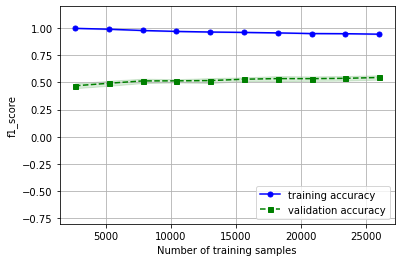

In [10]:
plt.plot(train_sizes, train_mean,color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('f1_score')
plt.legend(loc='lower right') 
plt.ylim([-0.8, 1.2])
plt.show()

Logistic regression

In [ ]:
Best_model=None
Best_score=0
Best_thresh = 0
c=0.0001
while c < 1000:
        clf = LogisticRegression(C=c)
        clf.fit(X_train, y_train)
        thresh, score = find_thresh_and_f1(clf, X_valid, y_valid)
        print(c,score)
        if score>Best_score:
            Best_model=clf
            Best_score= score
            Best_thresh = thresh
        c *= 10

In [13]:
y_pred = Best_model.predict_proba(X_test)
label = (y_pred[:,0] < Best_thresh).astype(np.int)
f1_logreg = f1_score(y_test,label)
best_logreg = Best_model 
thresh_logreg= Best_thresh
print("best logreg",best_logreg,'f1', f1_logreg)

best logreg LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) f1 0.5302390998593529


AdaBoost

In [ ]:
Best_model=None
Best_score=0
Best_thresh = 0
for n in range(1,20):
    for c in ["gini","entropy"]:
        for lr in [0.001,0.01, 0.1, 0.2, 0.5,1,10]:
            tree = DecisionTreeClassifier(criterion=c, 
                              max_depth=n,
                              random_state=0)
            clf = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=100, 
                         learning_rate=lr,
                         random_state=0)
            clf.fit(X_train, y_train)
            thresh, score = find_thresh_and_auc(clf, X_valid, y_valid)
            print(n, c, lr, score)
            if score>Best_score:
                Best_model=clf
                Best_score= score
                Best_thresh = thresh

In [ ]:
y_pred = Best_model.predict_proba(X_test)
label = (y_pred[:,0] < Best_thresh).astype(np.int)
f1_adab = f1_score(y_test,label)
best_adab = Best_model 
print("best adab",best_adab,'f1', f1_adab)
classification_report(y_test,y_pred)

SVM

In [7]:
bank_small = pd.read_csv('bank.csv')
bank_small = pd.DataFrame(bank_small)
X_train, y_train, X_valid, y_valid, X_test, y_test,final = prepareData(bank_small)
y_train.value_counts()

0    2561
1     331
Name: y, dtype: int64

In [8]:
param_grid = {'C': [0.001,0.01,0.1, 1, 10, 100, 1000],  
              'gamma': [100,10,1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','poly']}  
grid = GridSearchCV(SVC(probability=True), param_grid,n_jobs=4, refit = True, verbose = 3,scoring ='f1') 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   57.4s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:  1.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=3)

In [15]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 0.01, 'gamma': 1, 'kernel': 'poly'}
SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [ ]:
best_svm1 = grid.best_estimator_
y_pred =best_svm1.predict(X_test)
#label = (y_pred[:,0] < Best_thresh).astype(np.int)
f1_svm1 = f1_score(y_test,y_pred)
print("best svm",best_svm1,'f1', f1_svm1)

In [32]:
svm = SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
svm.fit(X_train,y_train)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [34]:
best_svm = svm
y_pred =best_svm.predict(X_test)
f1_svm = f1_score(y_test,y_pred)
print("best svm",best_svm,'f1', f1_svm)

best svm SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False) f1 0.4621893178212586


KNN

In [ ]:
Best_model=None
Best_score=0
Best_thresh = 0
for p in range(1,2):
    for k in range(2,20):
        clf = KNeighborsClassifier(n_neighbors=k, p=p,metric='minkowski')
        clf.fit(X_train, y_train)
        thresh, score = find_thresh_and_f1(clf, X_valid, y_valid)
        #print(p,k,score)
        if score>Best_score:
            Best_model=clf
            Best_score= score
            Best_thresh = thresh

In [38]:
y_pred = Best_model.predict_proba(X_test)
label = (y_pred[:,0] < Best_thresh).astype(np.int)
f1_knn = f1_score(y_test,label)
best_knn = Best_model 
print("best KNN",best_knn,'f1', f1_knn)

best KNN KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=1,
                     weights='uniform') f1 0.5046869141357331


MLPClassifier

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(150,150,150,100,50), max_iter=1000,activation = 'relu',solver='adam',random_state=1)
mlp.fit(X_train, y_train.values.ravel())

In [ ]:
mlp = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}


clf = GridSearchCV(mlp, parameter_space, n_jobs=-2, cv=5,scoring='f1')
clf.fit(X_train, y_train)


print('Best parameters found:\n', clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [40]:
best_adab =clf.best_estimator_
y_pred = best_adab.predict(X_test)
f1_nlp = f1_score(y_test,y_pred)
best_nlp =clf.best_estimator_
print("best adab",best_nlp,'f1', f1_nlp)

best adab MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False) f1 0.47584033613445376


SMOTE, UNDERSAMPLING

In [7]:
bank_small = pd.read_csv('bank.csv')
bank_small = pd.DataFrame(bank_small)
X_train, y_train, X_valid, y_valid, X_test, y_test,final = prepareData(bank_small)
y_train.value_counts()

0    2561
1     331
Name: y, dtype: int64

In [8]:
def overSMOTE(X_train,y_train,samp_strat):
    sm = SMOTE(sampling_strategy=samp_strat,k_neighbors=5,n_jobs=2)
    X_train, y_train = sm.fit_sample(X_train, y_train)
    y_train.value_counts()
    return X_train,y_train 

In [9]:
def concat(X_train,y_train,columns):
    df_y_train = pd.DataFrame(y_train,columns=['y'])
    df_X_train = pd.DataFrame(data=X_train,columns=columns)
    df_X_train.reset_index(drop=True, inplace=True)
    df_y_train.reset_index(drop=True, inplace=True)
    X= pd.concat([df_X_train, df_y_train], axis = 1)
    return X

In [10]:
def resamp(X,n_samples):
    not_subscribed = X[X.y==0]
    subscribed = X[X.y==1]

    not_subscribed_undersampled = resample(not_subscribed,
                              replace=False, 
                              n_samples=n_samples, 
                              random_state=1) 
    not_subscribed_undersampled.reset_index(drop=True, inplace=True)
    subscribed.reset_index(drop=True, inplace=True)
    undersampled = pd.concat([not_subscribed_undersampled,subscribed], axis = 0)
    print(undersampled.y.value_counts())
    y_train = undersampled.y
    X_train = undersampled.drop('y', axis=1)
    return X_train, y_train

In [11]:
X_train,y_train = overSMOTE(X_train,y_train,0.9)
y_train.value_counts()

0    2561
1    2304
Name: y, dtype: int64

In [ ]:
Best_model=None
Best_score=0
Best_thresh = 0

for C in [0.001,0.01,0.1,1,10,100,1000]:
    for gamma in [10,1, 0.1, 0.01, 0.001, 0.0001]:
        for kernel in ['rbf', 'poly']:
            clf = SVC(C=C,gamma=gamma,kernel=kernel,probability=True)
            clf.fit(X_train, y_train)
            thresh, score = find_thresh_and_f1(clf, X_valid, y_valid)
            print(C,gamma,score)
            if score>Best_score:
                Best_model=clf
                Best_score= score
                Best_thresh = thresh

In [14]:
best_svm_smote = Best_model
print(best_svm_smote)
y_pred = Best_model.predict_proba(X_test)
label = (y_pred[:,0] < Best_thresh).astype(np.int)
f1_score(y_test,label)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


0.5864661654135338

In [20]:
X_train, y_train, X_valid, y_valid, X_test, y_test,final = prepareData(bank)
columns = final.drop('y',axis=1).columns
X_train,y_train = overSMOTE(X_train,y_train,0.9)
y_train.value_counts()

0    25575
1    23017
Name: y, dtype: int64

In [17]:
columns = final.drop('y',axis=1).columns
X_train, y_train, X_valid, y_valid, X_test, y_test,final = prepareData(bank)
X_train, y_train = overSMOTE(X_train,y_train,0.7)
X = concat(X_train,y_train,columns)
X_train, y_train = resamp(X,17000) 
y_valid.value_counts()

1    17902
0    17000
Name: y, dtype: int64


0    6367
1     867
Name: y, dtype: int64

In [ ]:
Best_model=None
Best_score=0
Best_thresh = 0
for n in range(2,20):
    for c in ["gini","entropy"]:
        for mf in ["auto",None]:
            clf = RandomForestClassifier(max_depth=n, criterion=c, max_features=mf,n_jobs=2)
            clf.fit(X_train, y_train)
            thresh, score = find_thresh_and_f1(clf, X_valid, y_valid)
           # print(n, c, mf, score)
            if score>Best_score:
                Best_model=clf
                Best_score= score
                Best_thresh = thresh

In [19]:
# X_train, y_train = overSMOTE(X_train,y_train,0.7)
# X = concat(X_train,y_train,columns)
# X_train, y_train = resamp(X,17000) 

y_pred = Best_model.predict_proba(X_test)
label = (y_pred[:,0] < Best_thresh).astype(np.int)
f1_forest1 = f1_score(y_test,label)
thresh_forest1 = Best_thresh
best_forest1 = Best_model 
print("best forest",best_forest1,'f1', f1_forest1)

best forest RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=19, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False) f1 0.5953150242326333


In [22]:
# columns = final.drop('y',axis=1).columns
# X_train,y_train = overSMOTE(X_train,y_train,0.9)
# y_train.value_counts()

y_pred = Best_model.predict_proba(X_test)
label = (y_pred[:,0] < Best_thresh).astype(np.int)
f1_forest2 = f1_score(y_test,label)
thresh_forest2 = Best_thresh
best_forest2 = Best_model 
print("best forest",best_forest1,'f1', f1_forest1)

best forest RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=19, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False) f1 0.5953150242326333


In [ ]:
Best_model=None
Best_score=0
Best_thresh = 0
for p in [2]:
    for leaf_size in range(1,50):
        for k in range(2,20):
            clf = KNeighborsClassifier(n_neighbors=k, p=p,metric='minkowski',leaf_size=leaf_size)
            clf.fit(X_train, y_train)
            thresh, score = find_thresh_and_f1(clf, X_valid, y_valid)
            print(p,k,score)
            if score>Best_score:
                Best_model=clf
                Best_score= score
                Best_thresh = thresh

In [29]:
y_pred = Best_model.predict_proba(X_test)
label = (y_pred[:,0] < Best_thresh).astype(np.int)
f1_score(y_test,label)
best_knn_smote = Best_model
print(Best_model)

In [30]:
print(Best_knn_smote)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=1,
                     weights='uniform')


CONCLUSION

Imbalanced data are hard to deal with. After trying undersampling and oversampling methods we get best results with this imbalanced data using Random Forest algorithm eith parameters

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=16, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False) 